# Run RERF C++ vs CySPORF Side By Side on CC-18 Dataset

In [1]:
%load_ext lab_black

In [88]:
import sys
import os
from pathlib import Path
import numpy as np
import collections
from tqdm import tqdm
from pathlib import Path
import time
import logging
import json
from collections import defaultdict

import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append("../")

from oblique_forests.sporf import ObliqueForestClassifier

# from oblique_forests.ensemble import RandomForestClassifier
from rerf.rerfClassifier import rerfClassifier

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import cohen_kappa_score

import openml

from joblib import Parallel, delayed

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import cohen_kappa_score

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
benchmark_suite = openml.study.get_suite("OpenML-CC18")  # obtain the benchmark suite

In [6]:
data_dir = Path("/home/adam2392/Downloads/")
data_dir = Path("/Users/adam2392/Dropbox/sporf_benchmarks/")

In [8]:
folder = data_dir / f"cysporf_vs_c++/"
if not os.path.exists(folder):
    os.makedirs(folder)

In [112]:
n_splits = 5
random_state = 12345
n_estimators = 500
max_features = "auto"
feature_combinations = 1.5
n_jobs = -1

In [113]:
clfs = [
    (
        "rerfsporf",
        rerfClassifier(
            n_estimators=n_estimators,
            max_features=max_features,
            feature_combinations=feature_combinations,
            n_jobs=n_jobs,
            random_state=random_state,
        ),
    ),
    (
        "cysporf",
        ObliqueForestClassifier(
            n_estimators=n_estimators,
            max_features=max_features,
            feature_combinations=1.5,
            n_jobs=n_jobs,
            random_state=random_state,
        ),
    ),
]

# Setup Specific Task and Pipeline

In [96]:
task_id = None
for t_id in benchmark_suite.tasks:
    task = openml.tasks.get_task(t_id)  # download the OpenML task
    task_name = task.get_dataset().name
    if task_name == "climate-model-simulation-crashes":
        task_id = t_id
        break

In [114]:
print(f"{task_id} is for climate-model-simulation-crashes")

146819 is for climate-model-simulation-crashes


In [115]:
# get the task
task = openml.tasks.get_task(task_id)  # download the OpenML task

# get the data
X, y = task.get_X_and_y()
n_samples, n_features = X.shape
n_classes = len(np.unique(y))
sample_sizes = len(y)

nominal_indices = task.get_dataset().get_features_by_type("nominal", [task.target_name])

In [116]:
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

In [117]:
results_dict = defaultdict(list)

# Check if existing experiments
results_dict.update(
    {
        "task": task_name,
        "task_id": task_id,
        "n_samples": n_samples,
        "n_features": n_features,
        "n_classes": n_classes,
        "y": y,
        "test_indices": [],
        "n_estimators": n_estimators,
        "n_splits": n_splits,
        "nominal_features": len(nominal_indices),
        "sample_sizes": sample_sizes,
    }
)

In [118]:
# Get numeric indices first
numeric_indices = np.delete(np.arange(X.shape[1]), nominal_indices)

# Numeric Preprocessing
numeric_transformer = SimpleImputer(strategy="median")

# Nominal preprocessing
nominal_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)
transformers = []
if len(numeric_indices) > 0:
    transformers += [("numeric", numeric_transformer, numeric_indices)]
if len(nominal_indices) > 0:
    transformers += [("nominal", nominal_transformer, nominal_indices)]
preprocessor = ColumnTransformer(transformers=transformers)

_, n_features_fitted = preprocessor.fit_transform(X, y).shape
results_dict["n_features_fitted"] = n_features_fitted
print(
    f"Features={n_features}, nominal={len(nominal_indices)} (After transforming={n_features_fitted})"
)

Features=18, nominal=0 (After transforming=18)


# Run CV experiment with both classification models

In [119]:
fitted_clfs = defaultdict(list)
idx = 0

for train_index, test_index in tqdm(
    cv.split(X, y), total=cv.get_n_splits(), desc="k-fold"
):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    results_dict["test_indices"].append(test_index)

    for clf_name, clf in clfs:
        pipeline = Pipeline(steps=[("Preprocessor", preprocessor), ("Estimator", clf)])

        start_time = time.time()
        pipeline = pipeline.fit(X_train, y_train)
        train_time = time.time() - start_time

        # predict the probs of X test
        y_proba = pipeline.predict_proba(X_test)
        test_time = time.time() - (train_time + start_time)

        results_dict[f"{clf_name}_test_y_proba"].append(y_proba)
        results_dict[f"{clf_name}_train_times"].append(train_time)
        results_dict[f"{clf_name}_test_times"].append(test_time)

        fitted_clfs[clf_name].append(clf)
    idx += 1

k-fold: 100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


In [120]:
tasks = []
n_samples = []
n_classes = []
n_features = []
task_ids = []

rerf_cohens = []
sporf_cohens = []

In [121]:
result_dict = results_dict
# number of stratified cross-validations
n_splits = result_dict["n_splits"]
fold_test_inds = result_dict["test_indices"]
y = result_dict["y"]
task_name = result_dict["task"]
n_feature = result_dict["n_features"]

# extract metadata of benchmark experiment
tasks.append(task_name)
n_samples.append(result_dict["n_samples"])
n_classes.append(result_dict["n_classes"])
task_ids.append(result_dict["task_id"])
n_features.append(n_feature)

# compute cohen kappa for both classifiers
for clf in ["rerfsporf", "cysporf"]:
    clf_cohens = []
    fold_probas = result_dict[f"{clf}_test_y_proba"]

    # compute statistic on each fold
    for ifold in range(n_splits):
        y_proba = fold_probas[ifold]
        y_test = y[fold_test_inds[ifold]]
        kappa_score = cohen_kappa_score(y_test, y_proba.argmax(1))
        clf_cohens.append(kappa_score)

    if clf == "rerfsporf":
        rerf_cohens.append(clf_cohens)
    else:
        sporf_cohens.append(clf_cohens)

## Create DataFrames and Plots

In [122]:
print(rerf_cohens)
print(sporf_cohens)

[[0.0, 0.0, 0.0, 0.0, 0.0]]
[[0.0, 0.0, 0.0, 0.0, 0.0]]


In [83]:
result_df = pd.DataFrame((tasks, n_samples, n_classes, task_ids, n_features)).T
result_df.columns = ["task", "n_samples", "n_classes", "task_id", "n_features"]

In [85]:
rerf_df = pd.DataFrame(rerf_cohens)
rerf_df["clf"] = "rerf"
rerf_df = pd.concat((rerf_df, result_df), axis=1)

sporf_df = pd.DataFrame(sporf_cohens)
sporf_df["clf"] = "sporf"
sporf_df = pd.concat((sporf_df, result_df), axis=1)

diff_arr = np.array(sporf_cohens) - np.array(rerf_cohens)
diff_df = pd.DataFrame(diff_arr)
diff_df = pd.concat((diff_df, result_df), axis=1)

# now form the final dataframe
data_df = pd.concat((rerf_df, sporf_df), axis=0)

print(data_df.shape)
print(diff_df.shape)

(8, 16)
(4, 15)


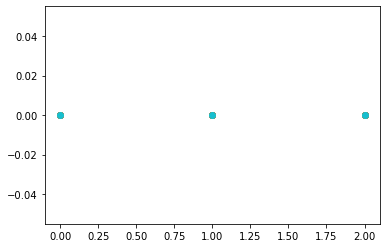

In [89]:
plt.plot(rerf_cohens, "*")
plt.plot(sporf_cohens, "o")